In [4]:
!pip install category_encoders
!pip install pytorch_tabnet

In [37]:
from category_encoders import LeaveOneOutEncoder
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from pytorch_tabnet.tab_model import TabNetRegressor, TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
np.random.seed(0)


# TabNet

In [6]:

df = pd.read_csv('https://docs.google.com/uc?id=10eFO2rVlsQBUffn0b7UCAp28n0mkLCy7&export=download')

labels = df.pop('<=50K')
class_to_int = {c: i for i, c in enumerate(labels.unique())}   
labels = [class_to_int[v] for v in labels]  

X_train, X_val, y_train_int, y_val_int = train_test_split(df, labels, test_size=0.2)

cat_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
#categorical_dims = dict()


display(X_train)
tmp = X_train.copy()
cat_encoder = LeaveOneOutEncoder()
cat_encoder.fit(X_train[cat_features], y_train_int)
X_train[cat_features] = cat_encoder.transform(X_train[cat_features])
X_val[cat_features] = cat_encoder.transform(X_val[cat_features])



display(X_train)
X_train = X_train.values.astype('float32')
X_val = X_val.values.astype('float32')
y_train = np.array(y_train_int)
y_val = np.array(y_val_int)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
15282,36,Private,174308,11th,7,Divorced,Transport-moving,Not-in-family,White,Male,0,0,40,United-States
24870,35,Private,198202,HS-grad,9,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,54,United-States
18822,38,Private,52963,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,50,United-States
26404,50,Private,138270,HS-grad,9,Married-civ-spouse,Sales,Wife,Black,Female,0,0,40,United-States
7842,68,Self-emp-not-inc,116903,Assoc-voc,11,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,2149,40,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,43,Local-gov,33331,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States
19648,44,Private,98466,10th,6,Never-married,Farming-fishing,Unmarried,White,Male,0,0,35,United-States
9845,23,Private,45317,Some-college,10,Separated,Sales,Own-child,White,Female,0,0,40,United-States
10799,45,Local-gov,215862,Doctorate,16,Married-civ-spouse,Exec-managerial,Husband,White,Male,7688,0,45,United-States


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
15282,36,0.216999,174308,0.046739,7,0.102637,0.203162,0.100709,0.254738,0.305831,0,0,40,0.24511
24870,35,0.216999,198202,0.159290,9,0.044455,0.484047,0.100709,0.254738,0.105960,0,0,54,0.24511
18822,38,0.216999,52963,0.418435,13,0.044455,0.132589,0.100709,0.254738,0.105960,0,0,50,0.24511
26404,50,0.216999,138270,0.159290,9,0.447245,0.269310,0.470973,0.123618,0.105960,0,0,40,0.24511
7842,68,0.286280,116903,0.251351,11,0.447245,0.447449,0.449796,0.254738,0.305831,0,2149,40,0.24511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,43,0.305307,33331,0.556577,14,0.447245,0.484047,0.449796,0.254738,0.305831,0,0,40,0.24511
19648,44,0.216999,98466,0.063830,6,0.044455,0.119647,0.061982,0.254738,0.305831,0,0,35,0.24511
9845,23,0.216999,45317,0.188957,10,0.071166,0.269310,0.013000,0.254738,0.105960,0,0,40,0.24511
10799,45,0.305307,215862,0.748366,16,0.447245,0.484047,0.449796,0.254738,0.305831,7688,0,45,0.24511


In [7]:
classifier = TabNetClassifier(verbose=0,seed=42)
classifier.fit(X_train=X_train, y_train=y_train,
               patience=5,max_epochs=100,
               eval_metric=['auc'])



No early stopping will be performed, last training weights will be used.


In [48]:
predictions = classifier.predict_proba(X_val)[:,1]
print(predictions, y_val)
valid_auc = roc_auc_score(y_score=predictions, y_true=y_val)
predictions[predictions > 0.5] = 1
predictions[predictions <= 0.5] = 0
#, y_valpredictions

[0.01063654 0.06961029 0.28196564 ... 0.8451264  0.23682082 0.40891224] [0 0 0 ... 1 0 1]


In [43]:
print('Accuracy', sum(predictions==y_val)/len(y_val))
print('Validation AUC', valid_auc)

Accuracy 0.8492246276677414
Validation AUC 0.9020082965652372


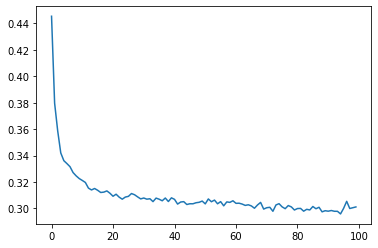

In [24]:
from matplotlib import pyplot as plt
plt.plot(classifier.history['loss'])

(array([6., 3., 1., 0., 1., 1., 1., 0., 0., 1.]),
 array([0.00094747, 0.02892751, 0.05690755, 0.08488759, 0.11286763,
        0.14084767, 0.16882772, 0.19680776, 0.2247878 , 0.25276784,
        0.28074788]),
 <a list of 10 Patch objects>)

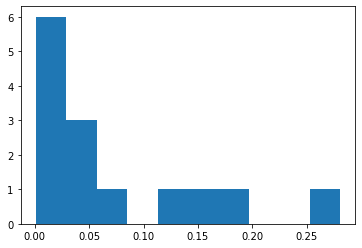

In [30]:
plt.hist(classifier.feature_importances_)

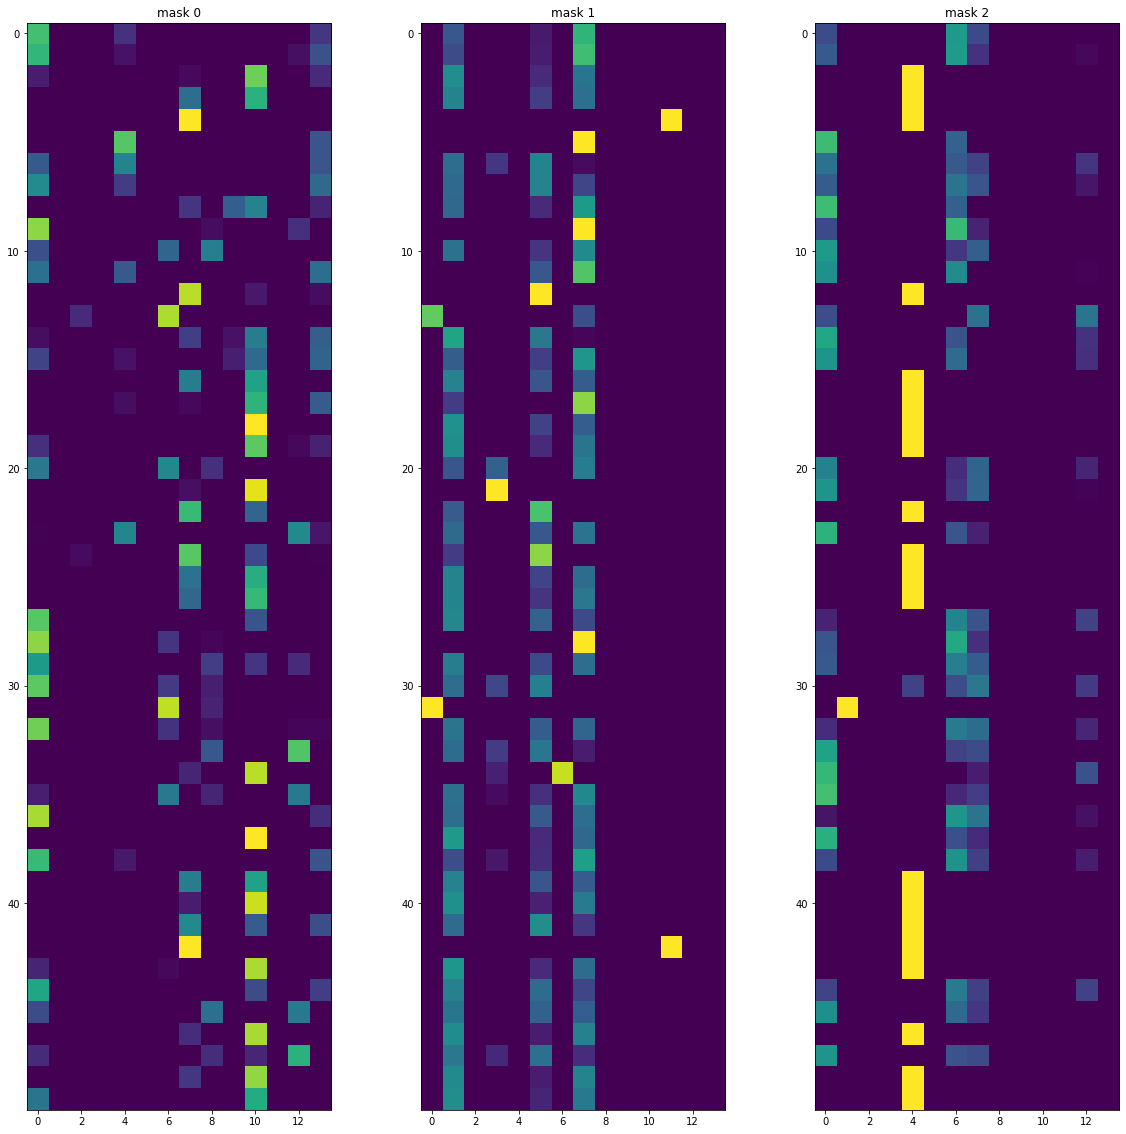

In [32]:
explain_matrix, masks = classifier.explain(X_val)
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

# XGB

In [34]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)


#For next time if we want val losses for every epoch use the eval_set flag

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=40,
        verbose=10)

[0]	validation_0-error:0.148319
Will train until validation_0-error hasn't improved in 40 rounds.
[10]	validation_0-error:0.137264
[20]	validation_0-error:0.138799
[30]	validation_0-error:0.135882
[40]	validation_0-error:0.133886
[50]	validation_0-error:0.132197
[60]	validation_0-error:0.133272
[70]	validation_0-error:0.13404
[80]	validation_0-error:0.132658
[90]	validation_0-error:0.132044
[100]	validation_0-error:0.131737
[110]	validation_0-error:0.131276
[120]	validation_0-error:0.132811
[130]	validation_0-error:0.133272
[140]	validation_0-error:0.133733
Stopping. Best iteration:
[102]	validation_0-error:0.131122



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=0)

In [53]:
preds = np.array(clf_xgb.predict_proba(X_val))
valid_auc = roc_auc_score(y_score=preds[:,1], y_true=y_val)
print('Validation AUC', valid_auc)

preds = preds[:, 1]
preds[preds > 0.5] = 1
preds[preds <= 0.5] = 0
print('Accuracy', sum(preds==y_val)/len(y_val))

Validation AUC 0.925226887092518
Accuracy 0.8688776293566712


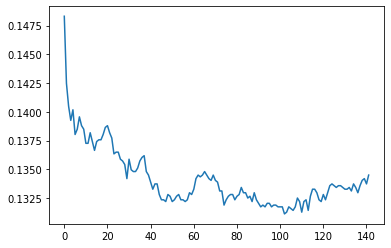

In [60]:
plt.plot(clf_xgb.evals_result()['validation_0']['error'])
plt.show()